In [ ]:
import kagglehub
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# Download latest version
path = kagglehub.dataset_download("ashish2001/semantic-segmentation-of-underwater-imagery-suim")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/semantic-segmentation-of-underwater-imagery-suim


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
train_img_dir = os.path.join(path, "train_val", "images")
train_mask_dir = os.path.join(path, "train_val", "masks")

test_img_dir = os.path.join(path, "TEST", "images")
test_mask_dir = os.path.join(path, "TEST", "masks")

Object Category	Symbol	RGB Code

Background (waterbody)	BW	000 (black)

Human divers	HD	001 (blue)

Aquatic plants and sea-grass	PF	010 (green)

Wrecks and ruins	WR	011 (sky)

Robots (AUVs/ROVs/instruments)	RO	100 (red)

Reefs and invertebrates	RI	101 (pink)

Fish and vertebrates	FV	110 (yellow)

Sea-floor and rocks	SR	111 (white)


In [ ]:
def mask_to_class(mask):
    h, w, _ = mask.shape
    class_mask = np.zeros((h, w), dtype=np.int64)

    for i in range(h):
        for j in range(w):
            r, g, b = mask[i, j]

            r = 255 if r >= 128 else 0
            g = 255 if g >= 128 else 0
            b = 255 if b >= 128 else 0

            if (r, g, b) == (0, 0, 0):
                class_mask[i, j] = 0  # фон

            elif (r, g, b) == (0, 0, 255):
                class_mask[i, j] = 1  # человек

            elif (r, g, b) == (255, 0, 0):
                class_mask[i, j] = 2  # робот

            elif (r, g, b) == (255, 255, 0):
                class_mask[i, j] = 3  # рыба

            else:
                class_mask[i, j] = 4  # всё остальное

    return class_mask


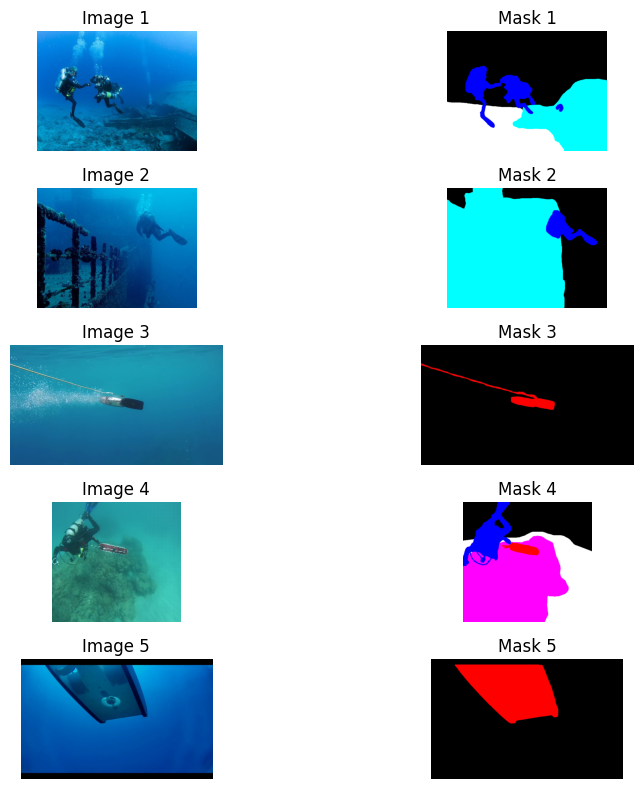

Image size: (1152, 720)
Mask size: (1152, 720)


In [ ]:
img_names  = sorted(os.listdir(train_img_dir))[:5]
mask_names = sorted(os.listdir(train_mask_dir))[:5]

plt.figure(figsize=(10, 8))

for i in range(5):
    image = Image.open(os.path.join(train_img_dir, img_names[i]))
    mask  = Image.open(os.path.join(train_mask_dir, mask_names[i]))

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    plt.axis("off")

    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(mask)
    plt.title(f"Mask {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

print("Image size:", image.size)
print("Mask size:", mask.size)


In [ ]:
class SUIMDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.samples = []

        imgs  = sorted(f for f in os.listdir(img_dir)
                       if f.endswith('.jpg'))
        masks = sorted(f for f in os.listdir(mask_dir)
                       if f.endswith('.bmp'))

        img_map  = {os.path.splitext(f)[0]: f for f in imgs}
        mask_map = {os.path.splitext(f)[0]: f for f in masks}

        for name in img_map:
            if name in mask_map:
                self.samples.append((
                    os.path.join(img_dir,  img_map[name]),
                    os.path.join(mask_dir, mask_map[name])
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        image = Image.open(img_path).convert("RGB").resize((320, 256))
        mask  = Image.open(mask_path).convert("RGB").resize((320, 256))

        image = torch.from_numpy(np.array(image) / 255.0).permute(2, 0, 1).float()
        mask  = torch.from_numpy(mask_to_class(np.array(mask))).long()

        return image, mask


In [ ]:
train_dataset = SUIMDataset(train_img_dir, train_mask_dir)
test_dataset  = SUIMDataset(test_img_dir, test_mask_dir)

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=2,shuffle=True,num_workers=2)
test_loader = DataLoader(test_dataset,batch_size=2,shuffle=False,num_workers=2)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class myNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(3, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.enc4 = DoubleConv(128, 256)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)

        # Decoder
        self.up4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec4 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = DoubleConv(256, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        # Output
        self.out = nn.Conv2d(32, num_classes, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x) # e1: (B,32,256,320)
        e2 = self.enc2(self.pool(e1)) # pool → (B,32,128,160), e2 → (B,64,128,160)
        e3 = self.enc3(self.pool(e2)) # pool → (B,64,64,80), e3 → (B,128,64,80)
        e4 = self.enc4(self.pool(e3)) # pool → (B,128,32,40),e4 → (B,256,32,40)

        b = self.bottleneck(self.pool(e4)) # pool → (B,256,16,20),b → (B,512,16,20)

        # Decoder + skip connections
        d4 = self.up4(b) # (B,512,16,20) → (B,256,32,40)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        # (B,256,32,40) + (B,256,32,40) → (B,512,32,40)
        # (B,512,32,40) → (B,256,32,40)

        d3 = self.up3(d4) # (B,256,32,40) → (B,128,64,80)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        # (B,128,64,80) + (B,128,64,80) → (B,256,64,80)
        # (B,256,64,80) → (B,128,64,80)

        d2 = self.up2(d3) # (B,128,64,80) → (B,64,128,160)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        # (B,64,128,160) + (B,64,128,160) → (B,128,128,160)
        # (B,128,128,160) → (B,64,128,160)

        d1 = self.up1(d2) # (B,64,128,160) → (B,32,256,320)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        # (B,32,256,320) + (B,32,256,320) → (B,64,256,320)
        # (B,64,256,320) → (B,32,256,320)

        return self.out(d1) # (B,5,256,320)

In [ ]:
model = myNet(num_classes=5).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,        # уменьшаем LR в 2 раза
    patience=3,        # ждём 3 эпохи без улучшения
    min_lr=1e-5,
)


In [ ]:
def pixel_accuracy(pred, target):
    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total


def compute_iou(pred, target, num_classes):
    ious = []

    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)

        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()

        if union == 0:
            continue

        ious.append(intersection / union)

    return sum(ious) / len(ious)


In [ ]:
def compute_f1(pred, target, num_classes):
    f1s = []

    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)

        tp = (pred_cls & target_cls).sum().item()
        fp = (pred_cls & ~target_cls).sum().item()
        fn = (~pred_cls & target_cls).sum().item()

        denom = 2 * tp + fp + fn
        if denom == 0:
            continue

        f1 = 2 * tp / denom
        f1s.append(f1)

    return sum(f1s) / len(f1s)

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_ious = []

    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        iou = compute_iou(preds, masks, num_classes=5)
        epoch_ious.append(iou)

    mean_iou = np.mean(epoch_ious)

    scheduler.step(mean_iou)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Loss: {epoch_loss/len(train_loader):.4f} | "
        f"Mean IoU: {mean_iou:.4f} | "
    )


100%|██████████| 763/763 [02:19<00:00,  5.47it/s]


Epoch [1/100] | Loss: 0.8411 | Mean IoU: 0.2877 | 


100%|██████████| 763/763 [02:04<00:00,  6.15it/s]


Epoch [2/100] | Loss: 0.7252 | Mean IoU: 0.3068 | 


100%|██████████| 763/763 [02:04<00:00,  6.14it/s]


Epoch [3/100] | Loss: 0.6885 | Mean IoU: 0.3186 | 


100%|██████████| 763/763 [02:04<00:00,  6.11it/s]


Epoch [4/100] | Loss: 0.6432 | Mean IoU: 0.3292 | 


100%|██████████| 763/763 [02:05<00:00,  6.10it/s]


Epoch [5/100] | Loss: 0.6224 | Mean IoU: 0.3405 | 


100%|██████████| 763/763 [02:06<00:00,  6.02it/s]


Epoch [6/100] | Loss: 0.6160 | Mean IoU: 0.3475 | 


100%|██████████| 763/763 [02:05<00:00,  6.09it/s]


Epoch [7/100] | Loss: 0.5896 | Mean IoU: 0.3494 | 


100%|██████████| 763/763 [02:06<00:00,  6.01it/s]


Epoch [8/100] | Loss: 0.5787 | Mean IoU: 0.3616 | 


100%|██████████| 763/763 [02:06<00:00,  6.04it/s]


Epoch [9/100] | Loss: 0.5642 | Mean IoU: 0.3623 | 


100%|██████████| 763/763 [02:03<00:00,  6.17it/s]


Epoch [10/100] | Loss: 0.5474 | Mean IoU: 0.3695 | 


100%|██████████| 763/763 [02:05<00:00,  6.08it/s]


Epoch [11/100] | Loss: 0.5374 | Mean IoU: 0.3732 | 


100%|██████████| 763/763 [02:05<00:00,  6.10it/s]


Epoch [12/100] | Loss: 0.5257 | Mean IoU: 0.3749 | 


100%|██████████| 763/763 [02:05<00:00,  6.09it/s]


Epoch [13/100] | Loss: 0.5111 | Mean IoU: 0.3767 | 


100%|██████████| 763/763 [02:03<00:00,  6.15it/s]


Epoch [14/100] | Loss: 0.5162 | Mean IoU: 0.3782 | 


100%|██████████| 763/763 [02:04<00:00,  6.11it/s]


Epoch [15/100] | Loss: 0.4994 | Mean IoU: 0.3805 | 


100%|██████████| 763/763 [02:05<00:00,  6.08it/s]


Epoch [16/100] | Loss: 0.5037 | Mean IoU: 0.3852 | 


100%|██████████| 763/763 [02:04<00:00,  6.11it/s]


Epoch [17/100] | Loss: 0.4953 | Mean IoU: 0.3883 | 


100%|██████████| 763/763 [02:05<00:00,  6.07it/s]


Epoch [18/100] | Loss: 0.4828 | Mean IoU: 0.3878 | 


100%|██████████| 763/763 [02:04<00:00,  6.15it/s]


Epoch [19/100] | Loss: 0.4876 | Mean IoU: 0.3905 | 


100%|██████████| 763/763 [02:04<00:00,  6.13it/s]


Epoch [20/100] | Loss: 0.4752 | Mean IoU: 0.3923 | 


100%|██████████| 763/763 [02:05<00:00,  6.09it/s]


Epoch [21/100] | Loss: 0.4720 | Mean IoU: 0.3901 | 


100%|██████████| 763/763 [02:04<00:00,  6.10it/s]


Epoch [22/100] | Loss: 0.4727 | Mean IoU: 0.3876 | 


100%|██████████| 763/763 [02:05<00:00,  6.10it/s]


Epoch [23/100] | Loss: 0.4652 | Mean IoU: 0.3914 | 


100%|██████████| 763/763 [02:04<00:00,  6.13it/s]


Epoch [24/100] | Loss: 0.4529 | Mean IoU: 0.3988 | 


100%|██████████| 763/763 [02:06<00:00,  6.04it/s]


Epoch [25/100] | Loss: 0.4565 | Mean IoU: 0.4062 | 


100%|██████████| 763/763 [02:04<00:00,  6.14it/s]


Epoch [26/100] | Loss: 0.4527 | Mean IoU: 0.4008 | 


100%|██████████| 763/763 [02:03<00:00,  6.17it/s]


Epoch [27/100] | Loss: 0.4395 | Mean IoU: 0.4030 | 


100%|██████████| 763/763 [02:03<00:00,  6.18it/s]


Epoch [28/100] | Loss: 0.4455 | Mean IoU: 0.4041 | 


100%|██████████| 763/763 [02:04<00:00,  6.13it/s]


Epoch [29/100] | Loss: 0.4330 | Mean IoU: 0.4047 | 


100%|██████████| 763/763 [02:04<00:00,  6.13it/s]


Epoch [30/100] | Loss: 0.4120 | Mean IoU: 0.4161 | 


100%|██████████| 763/763 [02:04<00:00,  6.15it/s]


Epoch [31/100] | Loss: 0.4015 | Mean IoU: 0.4240 | 


100%|██████████| 763/763 [02:04<00:00,  6.14it/s]


Epoch [32/100] | Loss: 0.4019 | Mean IoU: 0.4187 | 


100%|██████████| 763/763 [02:05<00:00,  6.08it/s]


Epoch [33/100] | Loss: 0.3949 | Mean IoU: 0.4257 | 


100%|██████████| 763/763 [02:05<00:00,  6.08it/s]


Epoch [34/100] | Loss: 0.3923 | Mean IoU: 0.4270 | 


100%|██████████| 763/763 [02:05<00:00,  6.09it/s]


Epoch [35/100] | Loss: 0.3875 | Mean IoU: 0.4279 | 


100%|██████████| 763/763 [02:04<00:00,  6.11it/s]


Epoch [36/100] | Loss: 0.3871 | Mean IoU: 0.4289 | 


100%|██████████| 763/763 [02:05<00:00,  6.08it/s]


Epoch [37/100] | Loss: 0.3923 | Mean IoU: 0.4236 | 


100%|██████████| 763/763 [02:06<00:00,  6.02it/s]


Epoch [38/100] | Loss: 0.3818 | Mean IoU: 0.4248 | 


100%|██████████| 763/763 [02:08<00:00,  5.95it/s]


Epoch [39/100] | Loss: 0.3841 | Mean IoU: 0.4337 | 


100%|██████████| 763/763 [02:06<00:00,  6.04it/s]


Epoch [40/100] | Loss: 0.3800 | Mean IoU: 0.4319 | 


100%|██████████| 763/763 [02:04<00:00,  6.14it/s]


Epoch [41/100] | Loss: 0.3749 | Mean IoU: 0.4355 | 


100%|██████████| 763/763 [02:03<00:00,  6.18it/s]


Epoch [42/100] | Loss: 0.3778 | Mean IoU: 0.4339 | 


100%|██████████| 763/763 [02:04<00:00,  6.12it/s]


Epoch [43/100] | Loss: 0.3769 | Mean IoU: 0.4327 | 


100%|██████████| 763/763 [02:03<00:00,  6.19it/s]


Epoch [44/100] | Loss: 0.3655 | Mean IoU: 0.4381 | 


100%|██████████| 763/763 [02:03<00:00,  6.18it/s]


Epoch [45/100] | Loss: 0.3632 | Mean IoU: 0.4449 | 


100%|██████████| 763/763 [02:02<00:00,  6.22it/s]


Epoch [46/100] | Loss: 0.3676 | Mean IoU: 0.4408 | 


100%|██████████| 763/763 [02:02<00:00,  6.21it/s]


Epoch [47/100] | Loss: 0.3583 | Mean IoU: 0.4470 | 


100%|██████████| 763/763 [02:03<00:00,  6.19it/s]


Epoch [48/100] | Loss: 0.3616 | Mean IoU: 0.4462 | 


100%|██████████| 763/763 [02:03<00:00,  6.20it/s]


Epoch [49/100] | Loss: 0.3582 | Mean IoU: 0.4464 | 


100%|██████████| 763/763 [02:04<00:00,  6.14it/s]


Epoch [50/100] | Loss: 0.3540 | Mean IoU: 0.4470 | 


100%|██████████| 763/763 [02:02<00:00,  6.24it/s]


Epoch [51/100] | Loss: 0.3546 | Mean IoU: 0.4476 | 


100%|██████████| 763/763 [02:03<00:00,  6.20it/s]


Epoch [52/100] | Loss: 0.3566 | Mean IoU: 0.4431 | 


100%|██████████| 763/763 [02:02<00:00,  6.24it/s]


Epoch [53/100] | Loss: 0.3483 | Mean IoU: 0.4493 | 


100%|██████████| 763/763 [02:03<00:00,  6.19it/s]


Epoch [54/100] | Loss: 0.3497 | Mean IoU: 0.4455 | 


100%|██████████| 763/763 [02:02<00:00,  6.21it/s]


Epoch [55/100] | Loss: 0.3447 | Mean IoU: 0.4541 | 


100%|██████████| 763/763 [02:02<00:00,  6.21it/s]


Epoch [56/100] | Loss: 0.3451 | Mean IoU: 0.4496 | 


100%|██████████| 763/763 [02:02<00:00,  6.21it/s]


Epoch [57/100] | Loss: 0.3408 | Mean IoU: 0.4569 | 


100%|██████████| 763/763 [02:02<00:00,  6.21it/s]


Epoch [58/100] | Loss: 0.3418 | Mean IoU: 0.4533 | 


100%|██████████| 763/763 [02:03<00:00,  6.16it/s]


Epoch [59/100] | Loss: 0.3369 | Mean IoU: 0.4532 | 


100%|██████████| 763/763 [02:03<00:00,  6.20it/s]


Epoch [60/100] | Loss: 0.3395 | Mean IoU: 0.4517 | 


100%|██████████| 763/763 [02:02<00:00,  6.23it/s]


Epoch [61/100] | Loss: 0.3316 | Mean IoU: 0.4587 | 


100%|██████████| 763/763 [02:02<00:00,  6.24it/s]


Epoch [62/100] | Loss: 0.3441 | Mean IoU: 0.4607 | 


100%|██████████| 763/763 [02:03<00:00,  6.18it/s]


Epoch [63/100] | Loss: 0.3353 | Mean IoU: 0.4608 | 


100%|██████████| 763/763 [02:03<00:00,  6.20it/s]


Epoch [64/100] | Loss: 0.3278 | Mean IoU: 0.4597 | 


100%|██████████| 763/763 [02:03<00:00,  6.17it/s]


Epoch [65/100] | Loss: 0.3272 | Mean IoU: 0.4616 | 


100%|██████████| 763/763 [02:03<00:00,  6.19it/s]


Epoch [66/100] | Loss: 0.3251 | Mean IoU: 0.4614 | 


100%|██████████| 763/763 [02:02<00:00,  6.23it/s]


Epoch [67/100] | Loss: 0.3255 | Mean IoU: 0.4605 | 


100%|██████████| 763/763 [02:03<00:00,  6.18it/s]


Epoch [68/100] | Loss: 0.3254 | Mean IoU: 0.4612 | 


100%|██████████| 763/763 [02:03<00:00,  6.20it/s]


Epoch [69/100] | Loss: 0.3170 | Mean IoU: 0.4656 | 


100%|██████████| 763/763 [02:02<00:00,  6.24it/s]


Epoch [70/100] | Loss: 0.3219 | Mean IoU: 0.4684 | 


100%|██████████| 763/763 [02:02<00:00,  6.21it/s]


Epoch [71/100] | Loss: 0.3161 | Mean IoU: 0.4692 | 


100%|██████████| 763/763 [02:03<00:00,  6.19it/s]


Epoch [72/100] | Loss: 0.3094 | Mean IoU: 0.4745 | 


100%|██████████| 763/763 [02:02<00:00,  6.21it/s]


Epoch [73/100] | Loss: 0.3117 | Mean IoU: 0.4699 | 


100%|██████████| 763/763 [02:03<00:00,  6.18it/s]


Epoch [74/100] | Loss: 0.3168 | Mean IoU: 0.4701 | 


100%|██████████| 763/763 [02:02<00:00,  6.21it/s]


Epoch [75/100] | Loss: 0.3041 | Mean IoU: 0.4752 | 


100%|██████████| 763/763 [02:02<00:00,  6.21it/s]


Epoch [76/100] | Loss: 0.3042 | Mean IoU: 0.4830 | 


100%|██████████| 763/763 [02:04<00:00,  6.13it/s]


Epoch [77/100] | Loss: 0.3119 | Mean IoU: 0.4697 | 


100%|██████████| 763/763 [02:04<00:00,  6.11it/s]


Epoch [78/100] | Loss: 0.3038 | Mean IoU: 0.4813 | 


100%|██████████| 763/763 [02:08<00:00,  5.94it/s]


Epoch [79/100] | Loss: 0.3022 | Mean IoU: 0.4792 | 


100%|██████████| 763/763 [02:05<00:00,  6.10it/s]


Epoch [80/100] | Loss: 0.3024 | Mean IoU: 0.4843 | 


100%|██████████| 763/763 [02:03<00:00,  6.17it/s]


Epoch [81/100] | Loss: 0.3008 | Mean IoU: 0.4822 | 


100%|██████████| 763/763 [02:03<00:00,  6.18it/s]


Epoch [82/100] | Loss: 0.2925 | Mean IoU: 0.4907 | 


100%|██████████| 763/763 [02:03<00:00,  6.16it/s]


Epoch [83/100] | Loss: 0.2919 | Mean IoU: 0.4855 | 


100%|██████████| 763/763 [02:03<00:00,  6.17it/s]


Epoch [84/100] | Loss: 0.2904 | Mean IoU: 0.4885 | 


100%|██████████| 763/763 [02:03<00:00,  6.17it/s]


Epoch [85/100] | Loss: 0.2860 | Mean IoU: 0.4924 | 


100%|██████████| 763/763 [02:04<00:00,  6.15it/s]


Epoch [86/100] | Loss: 0.2867 | Mean IoU: 0.4929 | 


100%|██████████| 763/763 [02:03<00:00,  6.19it/s]


Epoch [87/100] | Loss: 0.2832 | Mean IoU: 0.4921 | 


100%|██████████| 763/763 [02:04<00:00,  6.12it/s]


Epoch [88/100] | Loss: 0.2855 | Mean IoU: 0.4972 | 


100%|██████████| 763/763 [02:03<00:00,  6.16it/s]


Epoch [89/100] | Loss: 0.2812 | Mean IoU: 0.5024 | 


100%|██████████| 763/763 [02:03<00:00,  6.19it/s]


Epoch [90/100] | Loss: 0.2753 | Mean IoU: 0.5008 | 


100%|██████████| 763/763 [02:05<00:00,  6.10it/s]


Epoch [91/100] | Loss: 0.2732 | Mean IoU: 0.5018 | 


100%|██████████| 763/763 [02:04<00:00,  6.15it/s]


Epoch [92/100] | Loss: 0.2659 | Mean IoU: 0.5091 | 


100%|██████████| 763/763 [02:04<00:00,  6.15it/s]


Epoch [93/100] | Loss: 0.2737 | Mean IoU: 0.5082 | 


100%|██████████| 763/763 [02:03<00:00,  6.19it/s]


Epoch [94/100] | Loss: 0.2674 | Mean IoU: 0.5030 | 


100%|██████████| 763/763 [02:03<00:00,  6.18it/s]


Epoch [95/100] | Loss: 0.2616 | Mean IoU: 0.5061 | 


100%|██████████| 763/763 [02:02<00:00,  6.21it/s]


Epoch [96/100] | Loss: 0.2698 | Mean IoU: 0.5079 | 


100%|██████████| 763/763 [02:02<00:00,  6.21it/s]


Epoch [97/100] | Loss: 0.2421 | Mean IoU: 0.5330 | 


100%|██████████| 763/763 [02:03<00:00,  6.18it/s]


Epoch [98/100] | Loss: 0.2402 | Mean IoU: 0.5275 | 


100%|██████████| 763/763 [02:03<00:00,  6.17it/s]


Epoch [99/100] | Loss: 0.2423 | Mean IoU: 0.5242 | 


100%|██████████| 763/763 [02:02<00:00,  6.24it/s]

Epoch [100/100] | Loss: 0.2355 | Mean IoU: 0.5329 | 


In [ ]:
model.eval()

acc_list = []
iou_list = []
f1_list  = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks  = masks.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        acc_list.append(pixel_accuracy(preds, masks))
        iou_list.append(compute_iou(preds, masks, num_classes=5))
        f1_list.append(compute_f1(preds, masks, num_classes=5))

print("Pixel Accuracy:", np.mean(acc_list))
print("Mean IoU:", np.mean(iou_list))
print("Mean F1-score:", np.mean(f1_list))


Pixel Accuracy: 0.8276196289062501
Mean IoU: 0.41674761622603884
Mean F1-score: 0.4837545539627081


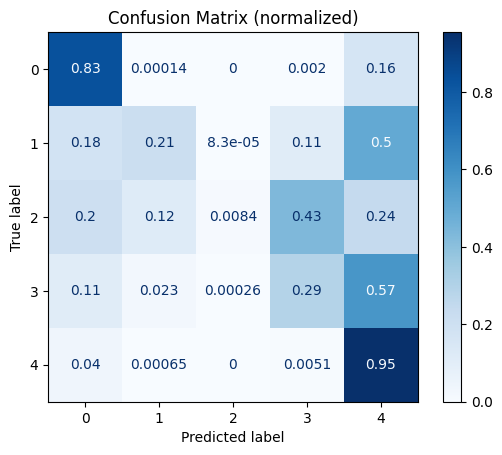

In [ ]:
all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        outputs = model(images)

        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy().flatten())
        all_targets.append(masks.cpu().numpy().flatten())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

cm = confusion_matrix(all_targets, all_preds, normalize='true')

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (normalized)")
plt.show()


<Figure size 1200x400 with 0 Axes>

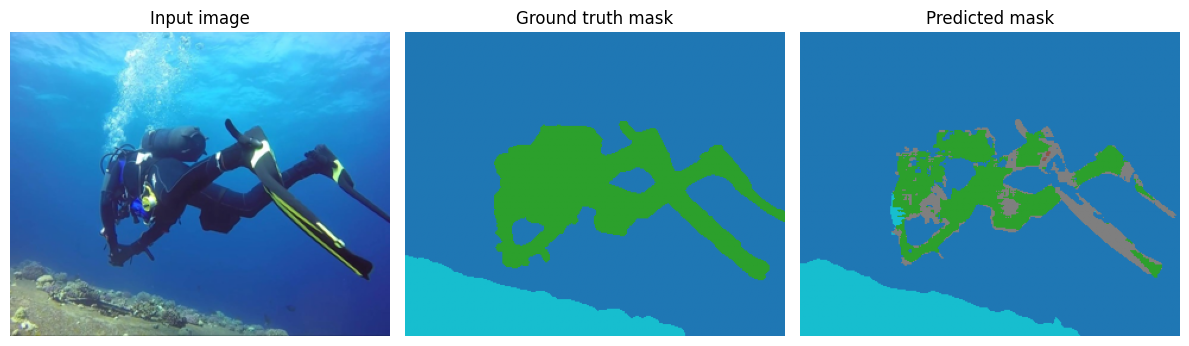

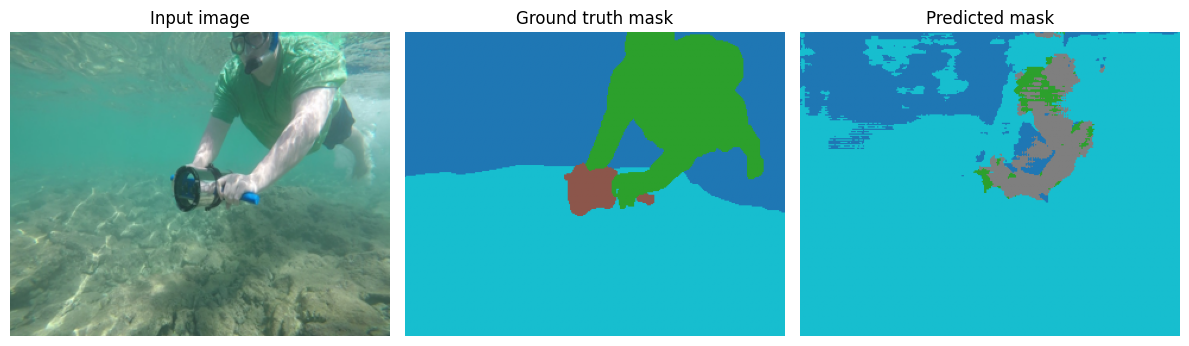

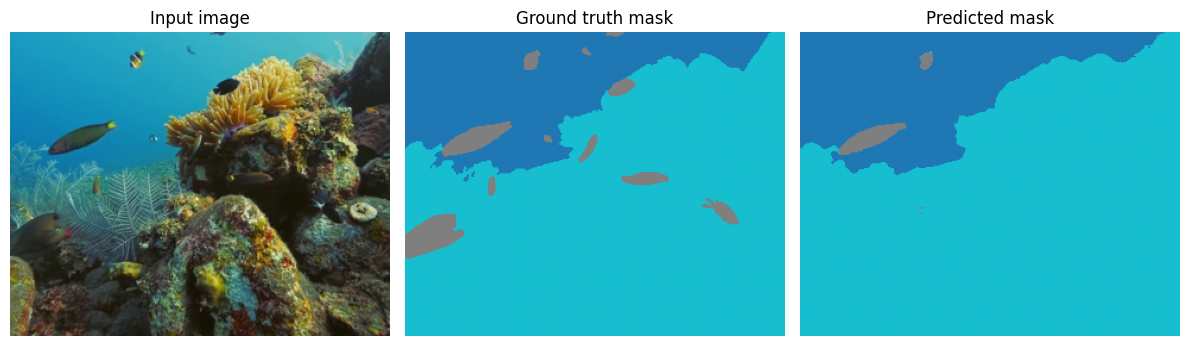

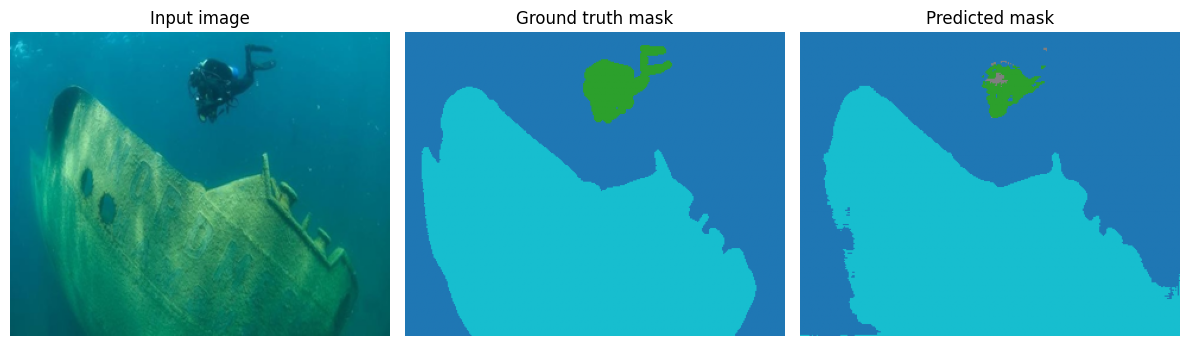

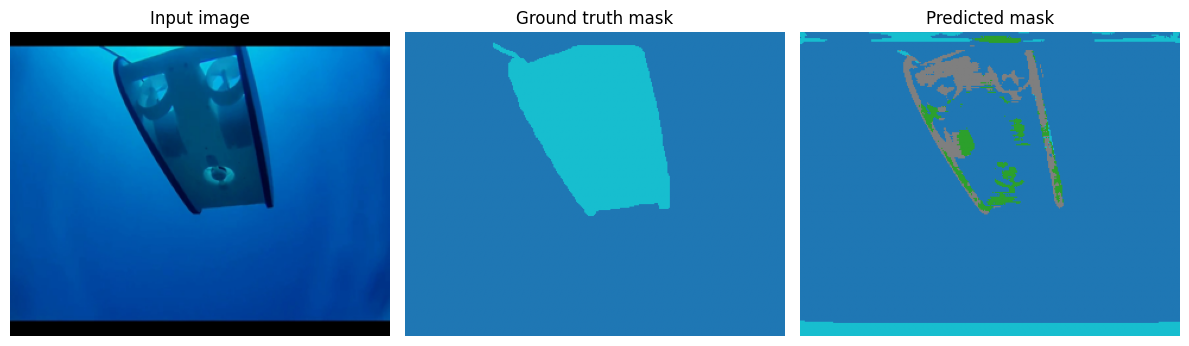

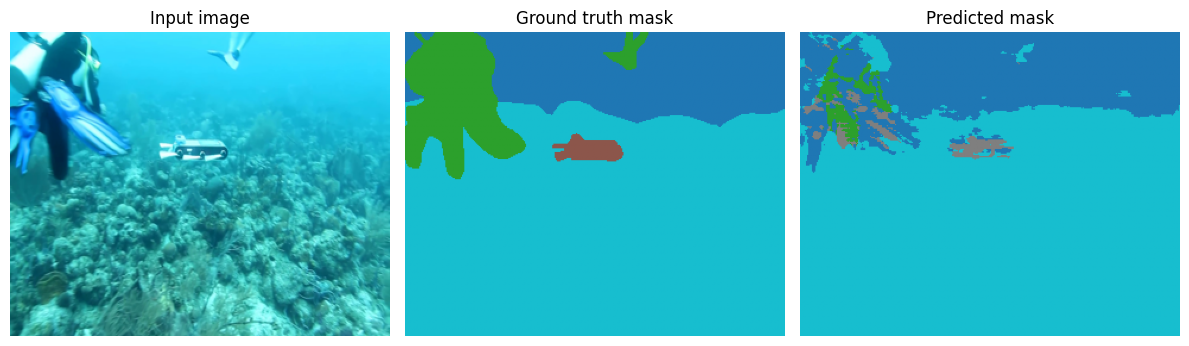

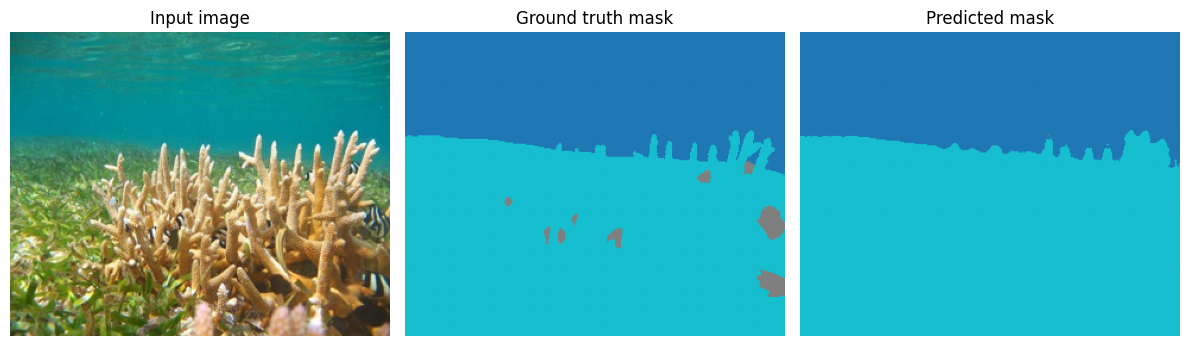

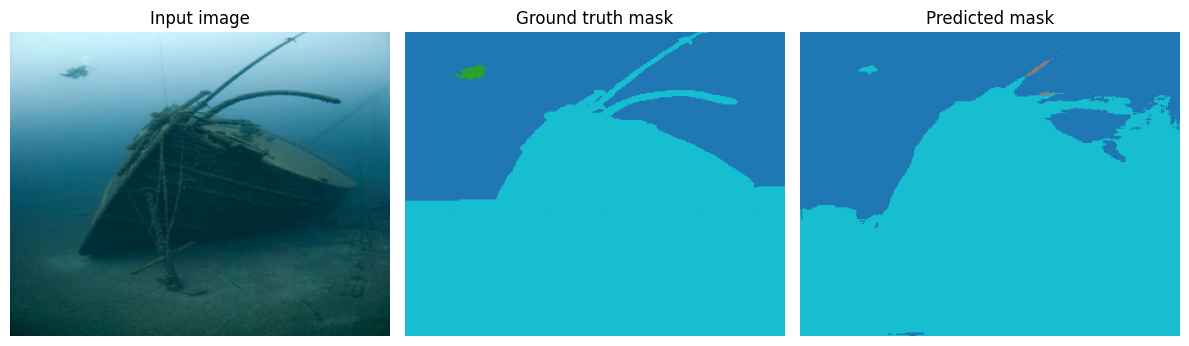

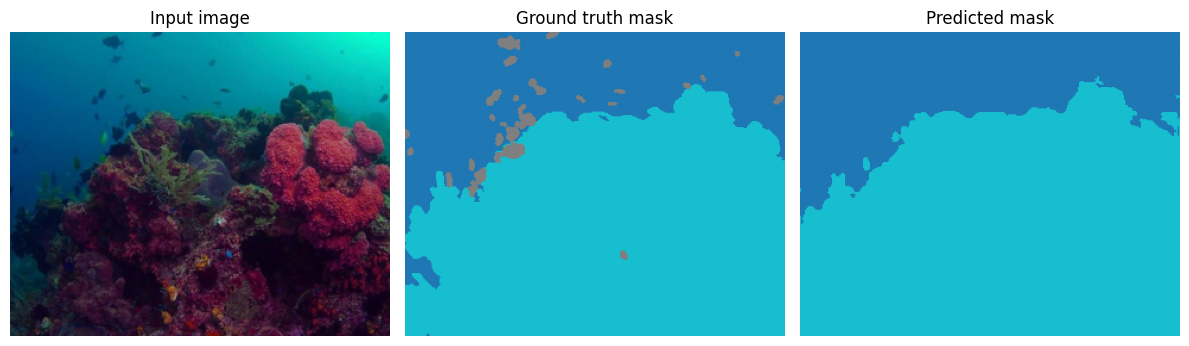

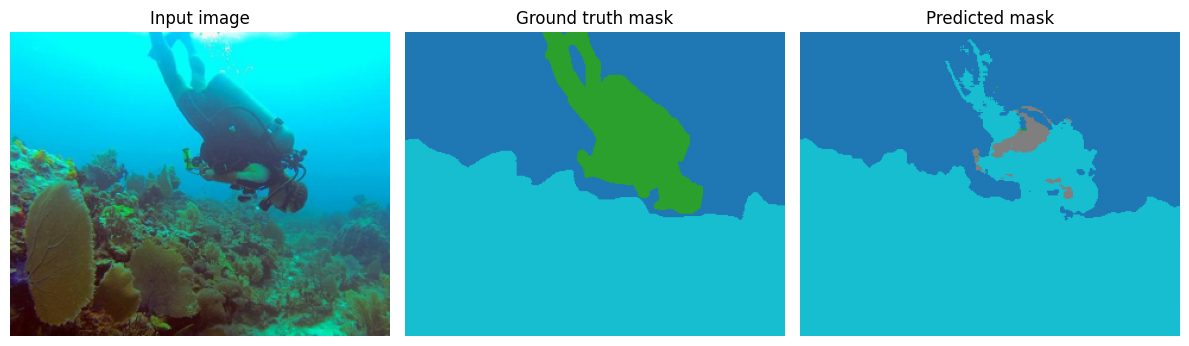

In [ ]:
import random

model.eval()

num_samples = 10
indices = random.sample(range(len(test_dataset)), num_samples)

plt.figure(figsize=(12, 4))

with torch.no_grad():
    for idx in indices:
        image, mask = test_dataset[idx]

        image = image.unsqueeze(0).to(device)
        mask  = mask.to(device)

        output = model(image)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        img = image.squeeze(0).cpu().permute(1, 2, 0).numpy()
        gt  = mask.cpu().numpy()

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Input image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt, cmap="tab10")
        plt.title("Ground truth mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap="tab10")
        plt.title("Predicted mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


In [ ]:
!jupyter nbconvert --to html /content/your_notebook.ipynb
